In [1]:
!pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)


ERROR: Invalid requirement: 'opencv-contrib-python,'


In [6]:
!pip install mediapipe --user

  Using cached mediapipe-0.10.14-cp39-cp39-win_amd64.whl (50.8 MB)
  Using cached jaxlib-0.4.30-cp39-cp39-win_amd64.whl (51.9 MB)
  Using cached opencv_contrib_python-4.10.0.84-cp37-abi3-win_amd64.whl (45.5 MB)
  Using cached sounddevice-0.5.0-py3-none-win_amd64.whl (189 kB)
  Using cached jax-0.4.30-py3-none-any.whl (2.0 MB)


In [4]:
!pip install opencv-python --user

In [3]:
!pip install numpy

In [4]:
!pip install pandas

In [5]:
!pip install tensorflow

  Using cached tensorflow-2.17.0-cp39-cp39-win_amd64.whl (2.0 kB)
     ------------------------------------ 385.0/385.0 MB 649.8 kB/s eta 0:00:00
     ---------------------------------------- 3.0/3.0 MB 750.9 kB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 598.1 kB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard-2.17.1-py3-none-any.whl (5.5 MB)
  Using cached termcolor-2.4.0-py3-none-any.whl (7.7 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Using cached ml_dtypes-0.4.0-cp39-cp39-win_amd64.whl (126 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl (26.4 MB)
  Using cached keras-3.5.0-py3-none-any.whl (1.1 MB)
     ---------------------------------------- 4.3/4.3 MB 406.9 kB/s eta 0:00:00
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orange3-text 1.15.0 requires anyqt, which is not installed.
orange3-text 1.15.0 requires httpx!=0.23.1, which is not installed.
orange3-text 1.15.0 requires orange-canvas-core, which is not installed.
orange3-text 1.15.0 requires orange-widget-base>=4.20.0, which is not installed.
orange3-text 1.15.0 requires Orange3>=3.34.0, which is not installed.
orange3-text 1.15.0 requires pyqtgraph, which is not installed.
orange3-text 1.15.0 requires serverfiles, which is not installed.
orange3-text 1.15.0 requires tweepy>=4.0.0, which is not installed.
spyder 5.2.2 requires pyqt5<5.13, which is not installed.
spyder 5.2.2 requires pyqtwebengine<5.13, which is not installed.


In [6]:
!pip install scikit-learn

In [7]:
!pip install matplotlib

In [7]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

In [8]:


# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, 
                    model_complexity=2, 
                    enable_segmentation=False, 
                    min_detection_confidence=0.5)

def extract_keypoints(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    
    if results.pose_landmarks:
        keypoints = []
        for lm in results.pose_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z, lm.visibility])
        return keypoints
    else:
        # Return a zero array if no landmarks are detected
        return [0] * 132  # 33 landmarks * 4 values each


In [5]:
import glob

# Define dataset path
dataset_path = 'dataset'

# Define classes
classes = ['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']

data = []
labels = []

for cls in classes:
    image_files = glob.glob(os.path.join(dataset_path, cls, '*.jpg'))  # Adjust extension if needed
    for img_path in image_files:
        keypoints = extract_keypoints(img_path)
        data.append(keypoints)
        labels.append(cls)

# Create DataFrame
df = pd.DataFrame(data)
df['label'] = labels

# Optionally save to CSV for future use
df.to_csv('pose_keypoints.csv', index=False)


C:\Users\nk683\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [9]:
# Load the dataset
df = pd.read_csv('pose_keypoints.csv')

classes = ['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']

# Check for any zero keypoints which indicate missing detections
df = df[~(df.iloc[:, :-1] == 0).all(axis=1)]  # Remove rows where all keypoints are zero


In [10]:
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, :-1].values
y = df['label'].values

# Normalize the keypoints
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler for future use
import joblib
joblib.dump(scaler, 'scaler.save')


['scaler.save']

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Save the label encoder
joblib.dump(le, 'label_encoder.save')


['label_encoder.save']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

num_classes = len(classes)
input_shape = X_train.shape[1]

model = Sequential([
    Dense(256, activation='relu', input_shape=(input_shape,)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.summary()


C:\Users\nk683\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          34,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,525 (295.02 KB)

 Trainable params: 75,525 (295.02 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)



history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.3881 - loss: 1.4909 - val_accuracy: 0.7908 - val_loss: 0.6856
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7393 - loss: 0.7637 - val_accuracy: 0.9133 - val_loss: 0.3995
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8192 - loss: 0.5891 - val_accuracy: 0.9235 - val_loss: 0.2801
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8375 - loss: 0.4692 - val_accuracy: 0.9286 - val_loss: 0.2272
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8617 - loss: 0.3863 - val_accuracy: 0.9337 - val_loss: 0.1988
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9003 - loss: 0.3036 - val_accuracy: 0.9388 - val_loss: 0.1758
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9406 - loss: 0.1976 - val_accuracy: 0.9541 - val_loss: 0.1376
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9321 - loss: 0.2044 - val_accuracy: 0.

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint callback
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]
)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9890 - loss: 0.0588 - val_accuracy: 0.9745 - val_loss: 0.0810
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9802 - loss: 0.0968 - val_accuracy: 0.9592 - val_loss: 0.1125
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9817 - loss: 0.0915 - val_accuracy: 0.9643 - val_loss: 0.1005
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9742 - loss: 0.0770 - val_accuracy: 0.9643 - val_loss: 0.1123
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9792 - loss: 0.0555 - val_accuracy: 0.9694 - val_loss: 0.1035
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9828 - loss: 0.0535 - val_accuracy: 0.9745 - val_loss: 0.0935
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9889 - loss: 0.0443 - val_accuracy: 0.9745 - val_loss: 0.0845
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9813 - loss: 0.0469 - val_accuracy: 0.96

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9845 - loss: 0.0557 - val_accuracy: 0.9847 - val_loss: 0.1093
Epoch 52/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9800 - loss: 0.0702 - val_accuracy: 0.9796 - val_loss: 0.1006
Epoch 53/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9864 - loss: 0.0242 - val_accuracy: 0.9796 - val_loss: 0.1005
Epoch 54/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9912 - loss: 0.0235 - val_accuracy: 0.9796 - val_loss: 0.0761
Epoch 55/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9908 - loss: 0.0364 - val_accuracy: 0.9796 - val_loss: 0.0805
Epoch 56/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9909 - loss: 0.0350 - val_accuracy: 0.9796 - val_loss: 0.0704
Epoch 57/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9919 - loss: 0.0275 - val_accuracy: 0.9796 - val_loss: 0.0985
Epoch 58/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9927 - loss: 0.0241 - val_accuracy: 0.9796 - va

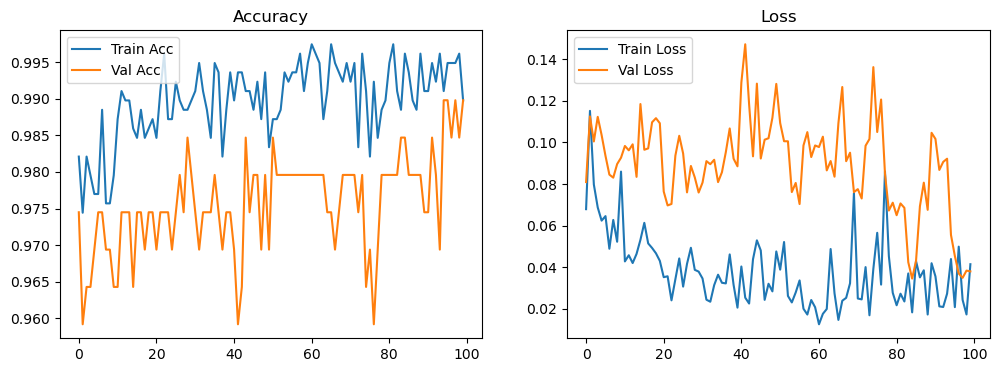

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9822 - loss: 0.0692  
Test Accuracy: 98.98%


In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

# Final evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')




In [21]:
from sklearn.metrics import classification_report

# Predict classes on the test data
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # Convert predictions to class labels if you are using softmax

# If y_test is one-hot encoded, convert it back to class labels
#y_true = y_test.argmax(axis=1)

# Generate and print the classification report
report = classification_report(y_test, y_pred_classes)
print(report)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        40
           2       0.97      1.00      0.99        39
           3       1.00      0.95      0.97        39
           4       0.97      1.00      0.99        39

    accuracy                           0.99       196
   macro avg       0.99      0.99      0.99       196
weighted avg       0.99      0.99      0.99       196

